<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [1]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [2]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [3]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [4]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [5]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [6]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [7]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [8]:
nltk.FreqDist([1,2,4])

FreqDist({1: 1, 2: 1, 4: 1})

In [9]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [10]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

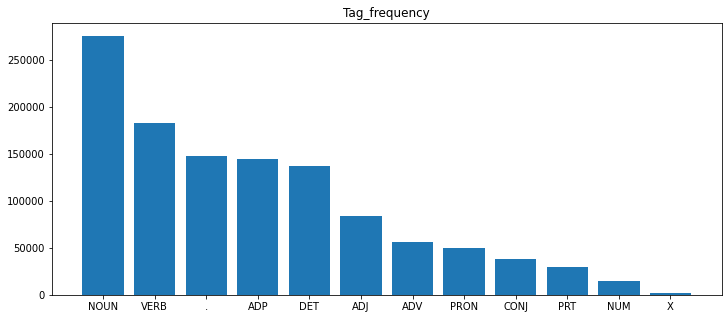

In [11]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [12]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

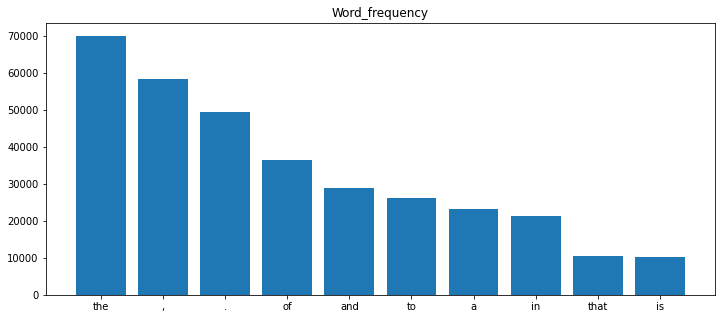

In [13]:
sample_size = 10

plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:sample_size], word_num.values[:sample_size])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [14]:
word_num['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [15]:
from collections import Counter

In [16]:
most_freq_tag = tag_num.index[0]

In [17]:
Counter(
    map(
        lambda x: x[0], 
        filter(lambda x: x[1] == most_freq_tag, brown_tagged_words)
    )
).most_common(1)

[('time', 1597)]

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [18]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [19]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, random_state=0,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [20]:
len(train_sents)

789

In [21]:
len(test_sents)

264

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
# https://www.coursera.org/lecture/language-processing/viterbi-algorithm-what-are-the-most-probable-tags-FMAba

class HiddenMarkovModel:
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег (строка предыдущее состояние - t, столбец следующее t + 1)
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self.B.max(axis=1).idxmax()  # max in columns (tag), max in selected column (word)
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    s = self.tags[i_s]
                    
                    # формула (1)
                    q[t + 1][i_s] = np.max(
                        q[t, :] * # все q с предыдущего шага
                        self.A.loc[s, :] * # вероятность перехода из тега s во все другие теги
                        self.B.loc[current_sent[t], s] # вероятность увидеть слово current_sent[t] при данном теге
                    )
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t, :] * self.A.loc[s, :] * 
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [ ]:
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'], 
         ['a', 'cat', 'and', 'a', 'dog'], 
         ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
my_model.predict(sents)

OrderedDict([(0, array(['CONJ', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['.', '.', '.', '.', '.'], dtype='<U1')),
             (2, array(['CONJ', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['CONJ', 'CONJ', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [ ]:
"VERB"

'VERB'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [ ]:
"CONJ"

'CONJ'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [37]:
from tqdm import tqdm

def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in tqdm(sents, leave=True):
        tags = np.array(list(map(lambda x: x[1], sent)))
        words = list(map(lambda x: x[0], sent))
        pred = my_model.predict([words])[0]
        true_pred += (pred == tags).sum()
        num_pred += len(words)
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [ ]:
accuracy_score(my_model, deepcopy(test_sents))

100%|██████████| 264/264 [02:23<00:00,  1.84it/s]

Accuracy: 62.82644934247082 %


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [ ]:
62.8

62.8

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [ ]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger(most_freq_tag)

In [ ]:
all_count = 0
true_count = 0
for sent in test_sents:
  pred = default_tagger.tag(sent)
  for el in pred:
    if el[1] == el[0][1]:
      true_count += 1
  all_count += len(pred)

print("Accuracy", float(true_count) / all_count)

Accuracy 0.2031857751435451


## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [22]:
from nltk.tag.mapping import map_tag

In [26]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [34]:
words, true_tags = zip(*train_sents[0])
print(words)

('bright', 'pinks', 'and', 'plaids', 'and', 'vivid', 'stripes', '.')


In [42]:
all_count = 0
true_count = 0
for sent in tqdm(test_sents, leave=True):
  words, true_tags = zip(*sent)
  _, pred_tags = zip(*nltk.pos_tag(words, tagset='universal'))

  all_count += len(words)
  true_count += (np.array(true_tags) == np.array(pred_tags)).sum()

print("\naccuracy: ", true_count / all_count)

100%|██████████| 264/264 [00:00<00:00, 779.61it/s]


accuracy:  0.8920170401926283


In [44]:
! pip install rnnmorph

     |████████████████████████████████| 19.7 MB 60.7 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 8.2 MB 46.2 MB/s 
  Created wheel for rnnmorph: filename=rnnmorph-0.4.1-py3-none-any.whl size=19746379 sha256=e71b02c692e9689fbe020dbbb795ead7f9ec30374f9f2433e2d7683078353802
  Stored in directory: /root/.cache/pip/wheels/b9/e8/8b/b4639d66ee5373f0db8dbe9a2ea94784c8e93fd52e9d2e811f
  Created wheel for russian-tagsets: filename=russian_tagsets-0.6-py3-none-any.whl size=24637 sha256=6922d9af9beb737d03345aa128031d4ddc3a0f3a6ca5f8256e559df29d3215ee
  Stored in directory: /root/.cache/pip/wheels/5e/b4/26/9c17a7cdcfc6b8cf43111312f3e7c6abb8e583599e37c422f8
Successfully built rnnmorph russian-tagsets


In [45]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [61]:
pred_tags = predictor.predict_sentences(list(map(lambda sent: list(zip(*sent))[0], test_sents)))

In [62]:
true_tags = list(map(lambda sent: list(zip(*sent))[1], test_sents))
pred_tags = [list(map(lambda x: x.pos, sent)) for sent in pred_tags]

In [64]:
all_count = 0
true_count = 0

for i in range(len(true_tags)):
  all_count += len(true_tags[i])
  true_count += (np.array(true_tags[i]) == np.array(pred_tags[i])).sum()

print("\naccuracy: ", true_count / all_count)


accuracy:  0.639562882015188


## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [87]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [88]:
from torchtext.legacy.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [89]:
print(vars(examples[0]))

{'words': ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], 'tags': ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']}


Теперь формируем наш датасет

In [90]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [91]:
WORD.build_vocab(train_data, min_freq=3)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 18057
Unique tokens in target (en) vocabulary: 13
['<unk>', 'though', 'boy', 'coming', 'farm', 'spent', 'distribution', 'faculty', 'arts', 'pleasure', 'games', "she's", 'chest', 'cup', 'relationships', 'supper', 'sciences', "they'll", 'prokofieff', 'innocence', 'root', 'vienna', 'assessment', 'beard', 'anticipation', 'selective', 'lucky', 'demanding', 'unemployment', 'minimize', 'commands', 'pottery', 'collecting', 'molecular', 'aided', 'ham', 'shivering', 'catching', 'keelson', "steele's", 'bryan', 'fuller', 'patriotic', 'thesis', 'brutal', 'faulty', 'multiplicity', 'slack', "1960's", "client's", 'fighter', 'liston', 'rca', 'trailed', 'arabic', 'complexes', 'erupted', 'homogeneous', 'meter', 'plywood', 'setup', 'totaled', '6-hr.', 'bel', 'confronts', 'economists', "gabriel's", 'inflict', 'martha', 'persist', 'responsive', 'spice', 'turks', '130', "andy's", 'bldg.', 'choctaws', 'crowning', 'dogmatism', 'feats', 'greenville', 'indignities', 'leng

In [92]:
print(vars(train_data.examples[9]))

{'words': ['welch', 'was', 'worried', '.'], 'tags': ['NOUN', 'VERB', 'VERB', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

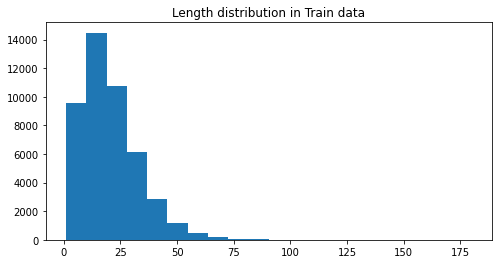

In [15]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [17]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [18]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

### Модель и её обучение

Инициализируем нашу модель

In [70]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=bidirectional)
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.embeddings(sent)
        embedded = self.dropout(embedded)

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 300
HID_DIM = 300
DROPOUT = 0.1
BIDIRECTIONAL = True

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(18057, 300)
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(300, 300, bidirectional=True)
  (tag): Linear(in_features=600, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,869,713 trainable parameters


Погнали обучать

In [72]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):  
        optimizer.zero_grad()
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        output = model(batch.words).reshape(-1, OUTPUT_DIM)
        tags = batch.tags.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        
        loss = criterion(output, tags)
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = model(batch.words).reshape(-1, OUTPUT_DIM)
            tags = batch.tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

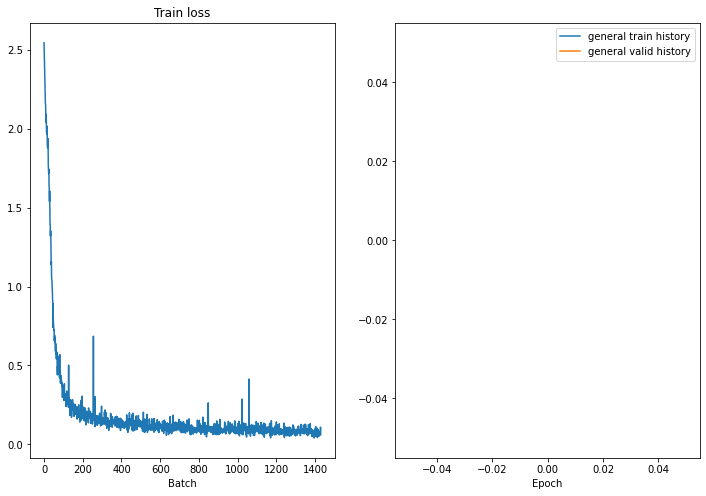

100%|██████████| 1/1 [01:38<00:00, 98.38s/it]

Epoch: 01 | Time: 1m 38s
	Train Loss: 0.186 | Train PPL:   1.204
	 Val. Loss: 0.095 |  Val. PPL:   1.100


In [73]:
import time
import tqdm
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 1
CLIP = 10

best_valid_loss = float('inf')

for epoch in tqdm.tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [81]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):            
            output = model(batch.words).reshape(-1, OUTPUT_DIM)
            tags = batch.tags.view(-1)
            
            #output = [sent len, batch size, output dim]
            output = output.argmax(axis=1)
            
            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [82]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 96.934 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [86]:
# brown_tagged_sents = brown.tagged_sents(tagset="universal")

Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [83]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93

Пример решение нашей задачи:

In [84]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [85]:
print_tags(model, pos_data[-1])

From           VERB
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

In [94]:
# Лучше всего показала на всем корпусе данных LSTM модель 96,6%, HiddenMarkov 62,8%